# IMPORTS

In [15]:
import csv
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import heapq
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import seaborn
import random
import wandb

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
!wandb login 3c81526a5ec348850a4c9d0f852f6631959307ed

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# PREPROCESSING

In [6]:
def loadData(params):
    language = params['language']
    dataset_path = params['dataset_path']
    train_path = os.path.join(dataset_path, language, language + '_train.csv')
    val_path = os.path.join(dataset_path, language, language + '_valid.csv')
    test_path = os.path.join(dataset_path, language, language + '_test.csv')
    train_data = csv.reader(open(train_path,encoding='utf8'))
    val_data = csv.reader(open(val_path,encoding='utf8'))
    test_data = csv.reader(open(test_path,encoding='utf8'))
    train_words , train_translations = [], []
    val_words , val_translations = [], []
    test_words , test_translations = [], []
    pad, start, end ='', '^', '$'
    
    for pair in train_data:
        train_words.append(pair[0] + end)
        train_translations.append(start + pair[1] + end)
    for pair in val_data:
        val_words.append(pair[0] + end)
        val_translations.append(start + pair[1] + end)
    for pair in test_data:
        test_words.append(pair[0] + end)
        test_translations.append(start + pair[1] + end)
    
    train_words , train_translations = np.array(train_words), np.array(train_translations)
    val_words , val_translations = np.array(val_words), np.array(val_translations)
    test_words , test_translations = np.array(test_words), np.array(test_translations)
    inout_vocab = set()
    output_vocab = set()
    
    for w in train_words:
        for c in w:
            inout_vocab.add(c)
    for w in val_words:
        for c in w:
            inout_vocab.add(c)
    for w in test_words:
        for c in w:
            inout_vocab.add(c)
            
    for w in train_translations:
        for c in w:
            output_vocab.add(c)
    for w in val_translations:
        for c in w:
            output_vocab.add(c)
    for w in test_translations:
        for c in w:
            output_vocab.add(c)
    
    inout_vocab.remove(end)
    output_vocab.remove(start)
    output_vocab.remove(end)  
    inout_vocab, output_vocab = [pad, start, end] + list(sorted(inout_vocab)), [pad, start, end] + list(sorted(output_vocab))
            
    input_index = dict([(char, idx) for idx, char in enumerate(inout_vocab)])
    output_index =  dict([(char, idx) for idx, char in enumerate(output_vocab)])
    input_index_rev = dict([(idx, char) for char, idx in input_index.items()])
    output_index_rev = dict([(idx, char) for char, idx in output_index.items()])
    
    max_enc_len = max([len(word) for word in np.hstack((train_words, test_words, val_words))])
    max_dec_len = max([len(word) for word in np.hstack((train_translations, val_translations, test_translations))])
    max_len = max(max_enc_len, max_dec_len)
        
    preprocessed_data = {
        'SOS' : start,
        'EOS' : end,
        'PAD' : pad,
        'train_words' : train_words,
        'train_translations' : train_translations,
        'val_words' : val_words,
        'val_translations' : val_translations,
        'test_words' : test_words,
        'test_translations' : test_translations,
        'max_enc_len' : max_enc_len,
        'max_dec_len' : max_dec_len,
        'max_len' : max_len,
        'input_index' : input_index,
        'output_index' : output_index,
        'input_index_rev' : input_index_rev,
        'output_index_rev' : output_index_rev
    }
    return preprocessed_data

In [7]:
def create_tensor(preprocessed_data):
    input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['train_words'])), dtype = 'int64')
    output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['train_words'])), dtype = 'int64')
    
    val_input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['val_words'])), dtype = 'int64')
    val_output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['val_words'])), dtype = 'int64')
    
    test_input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['test_words'])), dtype = 'int64')
    test_output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['test_words'])), dtype = 'int64')
    
    for idx, (w, t) in enumerate(zip(preprocessed_data['train_words'], preprocessed_data['train_translations'])):
        for i, char in enumerate(w):
            input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            output_data[i, idx] = preprocessed_data['output_index'][char]
        
    for idx, (w, t) in enumerate(zip(preprocessed_data['val_words'], preprocessed_data['val_translations'])):
        for i, char in enumerate(w):
            val_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            val_output_data[i, idx] = preprocessed_data['output_index'][char]
    
    for idx, (w, t) in enumerate(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])):
        for i, char in enumerate(w):
            test_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            test_output_data[i, idx] = preprocessed_data['output_index'][char]
    
    input_data, output_data = torch.tensor(input_data,dtype = torch.int64), torch.tensor(output_data, dtype = torch.int64)
    val_input_data, val_output_data = torch.tensor(val_input_data,dtype = torch.int64), torch.tensor(val_output_data, dtype = torch.int64)
    test_input_data, test_output_data = torch.tensor(test_input_data,dtype = torch.int64), torch.tensor(test_output_data, dtype = torch.int64)
    
    tensors = {
        'input_data' : input_data,
        'output_data' : output_data,
        'val_input_data' : val_input_data,
        'val_output_data' : val_output_data, 
        'test_input_data' : test_input_data,
        'test_output_data' : test_output_data
    }
    return tensors

In [8]:
# language = 'hin'
# # dataset_path = r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled'
# dataset_path = '/kaggle/input/dl-ass3/aksharantar_sampled'

# train_path = os.path.join(dataset_path, language, language + '_train.csv')
# val_path = os.path.join(dataset_path, language, language + '_valid.csv')
# test_path = os.path.join(dataset_path, language, language + '_test.csv')
# preprocessed_data = loadData(train_path, val_path, test_path)
# tensors = create_tensor(preprocessed_data)

# print('Input data : ', preprocessed_data['train_words'])
# print('Output data : ', preprocessed_data['train_translations'])
# print('Number of samples : ', len(preprocessed_data['train_words']))

# print('Input data : ', preprocessed_data['val_words'])
# print('Output data : ', preprocessed_data['val_translations'])
# print('Number of val samples : ', len(preprocessed_data['val_words']))

# print('Input data : ', preprocessed_data['test_words'])
# print('Output data : ', preprocessed_data['test_translations'])
# print('Number of test samples : ', len(preprocessed_data['test_words']))

# print('Max incoder length : ', preprocessed_data['max_enc_len'])
# print('Max decoder length : ', preprocessed_data['max_dec_len'])

# print('Input index length', len(preprocessed_data['input_index']))
# print('Output index length', len(preprocessed_data['output_index']))
# print('Input index', preprocessed_data['input_index'])
# print('Output index', preprocessed_data['output_index'])
# print('Input index Rev', preprocessed_data['input_index_rev'])
# print('Output index Rev', preprocessed_data['output_index_rev'])

# print('Input Data', tensors['input_data'].shape)
# print('Output Data', tensors['output_data'].shape)
# print('Input Data Val', tensors['val_input_data'].shape)
# print('Output Data Val', tensors['val_output_data'].shape)
# print('Input Data Test', tensors['test_input_data'].shape)
# print('Output Data Test', tensors['test_output_data'].shape)

# # print(tensors['input_data'][:,0])
# # print(tensors['output_data'][:,0])

# Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, params, preprocessed_data):
        super(Encoder, self).__init__()
        self.cell_type = params['cell_type']
        self.embedding = nn.Embedding(len(preprocessed_data['input_index']), params['embedding_size'])
        self.dropout = nn.Dropout(params['dropout'])
        if self.cell_type == 'RNN':
            self.cell = nn.RNN(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], bidirectional = params['bi_dir'])
        if self.cell_type == 'LSTM':
            self.cell = nn.LSTM(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], bidirectional = params['bi_dir'])
        if self.cell_type == 'GRU':
            self.cell = nn.GRU(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], bidirectional = params['bi_dir'])
        self.fc_hidden = nn.Linear(params['hidden_size'] * 2, params['hidden_size'])
        self.fc_cell = nn.Linear(params['hidden_size'] * 2, params['hidden_size'])

    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        if self.cell_type == 'LSTM':
            encoder_states, (hidden, cell) = self.cell(embedding)
            cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
            hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
            return encoder_states, hidden, cell
        else:
            encoder_states, hidden = self.cell(embedding)
            hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
            return encoder_states, hidden

# Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, params, preprocessed_data):
        super(Decoder, self).__init__()
        self.cell_type = params['cell_type']
        self.embedding = nn.Embedding(len(preprocessed_data['output_index']), params['embedding_size'])
        if self.cell_type == 'RNN':
            self.cell = nn.RNN(params['hidden_size'] * 2 + params['embedding_size'], params['hidden_size'], params['num_layers_enc'])
        if self.cell_type == 'LSTM':
            self.cell = nn.LSTM(params['hidden_size'] * 2 + params['embedding_size'], params['hidden_size'], params['num_layers_enc'])
        if self.cell_type == 'GRU':
            self.cell = nn.GRU(params['hidden_size'] * 2 + params['embedding_size'], params['hidden_size'], params['num_layers_enc'])
        self.energy = nn.Linear(params['hidden_size'] * 3, 1)
        self.fc = nn.Linear(params['hidden_size'], len(preprocessed_data['output_index']))
        self.dropout = nn.Dropout(params['dropout'])
        self.softmax = nn.Softmax(dim=0)
        # self.relu = nn.Hardshrink()
        # self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        embedding = self.dropout(self.embedding(x))
        h_reshaped = hidden.repeat(encoder_states.shape[0], 1, 1)
        energy = self.energy(torch.cat((h_reshaped, encoder_states), dim=2))
        # energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        attention = self.softmax(energy)
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)
        rnn_input = torch.cat((context_vector, embedding), dim=2)
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.cell(rnn_input, (hidden, cell))
            predictions = self.fc(outputs).squeeze(0)
            return predictions, hidden, cell, attention
        else:
            outputs, (hidden) = self.cell(rnn_input, (hidden))
            predictions = self.fc(outputs).squeeze(0)
            return predictions, hidden, attention

# Seq2Seq

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, params,  preprocessed_data):
        super(Seq2Seq, self).__init__()
        self.cell_type = params['cell_type']
        self.decoder, self.encoder  = decoder, encoder
        self.output_index_len = len(preprocessed_data['output_index'])
        self.tfr = params['teacher_fr']

    def forward(self, source, target):
        batch_size, target_len = source.shape[1], target.shape[0]
        x = target[0]
        outputs = torch.zeros(target_len, batch_size, self.output_index_len).to(device)
        if self.cell_type == 'LSTM':
            encoder_op, hidden, cell = self.encoder(source)
        else:    
            encoder_op, hidden = self.encoder(source)
        for t in range(1, target_len):
            if self.cell_type == 'LSTM':
                output, hidden, cell, _ = self.decoder(x, encoder_op, hidden, cell)
            else:    
                output, hidden, _ = self.decoder(x, encoder_op, hidden, None)
            outputs[t], best_guess = output, output.argmax(1)
            x = best_guess if random.random() >= self.tfr else target[t]
        return outputs

# GET OPTIMIZERS

In [12]:
def get_optim(model, params):
    if params['optimizer'].lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr = params['learning_rate'], momentum = 0.9)
    if params['optimizer'].lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'], betas = (0.9, 0.999), eps = 1e-8)
    if params['optimizer'].lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr = params['learning_rate'], alpha = 0.99, eps = 1e-8)
    if params['optimizer'].lower() == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr = params['learning_rate'], lr_decay = 0, weight_decay = 0, initial_accumulator_value = 0, eps = 1e-10)
    return optimizer

# GET TOTAL PARAMETERS

In [13]:
def get_total_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# BEAM SEARCH

In [30]:
def beam_search(model, word, preprocessed_data, params):
    data = np.zeros((preprocessed_data['max_len'] + 1, 1), dtype=np.int32)
    for idx, char in enumerate(word):
        data[idx, 0] = preprocessed_data['input_index'][char]
    data[idx + 1, 0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data, dtype=torch.int32).to(device)
    with torch.no_grad():
        if params['cell_type'] == 'LSTM':
           outputs, hidden, cell = model.encoder(data)
        else:
           outputs, hidden = model.encoder(data)
    output_start = preprocessed_data['output_index'][preprocessed_data['SOS']]
    out_reshape = np.array(output_start).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(out_reshape).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]
    attention_matrix = []
    for i in range(len(preprocessed_data['output_index'])):
        candidates = []
        for score, seq, hidden in beam:
            if seq[-1].item() == preprocessed_data['output_index'][preprocessed_data['EOS']]:
                candidates.append((score, seq, hidden))
                continue
            reshape_last = np.array(seq[-1].item()).reshape(1, )
            hdn = hidden.squeeze(0) 
            x = torch.tensor(reshape_last).to(device)
            if params['cell_type'] == 'LSTM':
                output, hidden, cell, attention_wt = model.decoder(x, outputs, hdn, cell)
            else:
                output, hidden, attention_wt = model.decoder(x, outputs, hdn, None)
            attention_matrix.append(attention_wt.detach().cpu().numpy())
            topk_probs, topk_tokens = torch.topk(F.softmax(output, dim=1), k = params['beam_width'])               
            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                ln_ns = len(new_seq)
                ln_pf = ((ln_ns - 1) / 5)
                candidate_score = score + torch.log(prob).item() / (ln_pf ** params['length_penalty'])
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
        beam = heapq.nlargest(params['beam_width'], candidates, key=lambda x: x[0])
    _, best_sequence, _ = max(beam, key=lambda x: x[0]) 
    prediction = ''.join([preprocessed_data['output_index_rev'][token.item()] for token in best_sequence[1:]])
    return prediction[:-1], attention_matrix         


# TRAIN MODEL

In [15]:
def train(model, criterion, optimizer, preprocessed_data, tensors, params):
    train_data, train_result = torch.split(tensors['input_data'], params['batch_size'], dim = 1), torch.split(tensors['output_data'], params['batch_size'], dim = 1)
    val_data, val_result = torch.split(tensors['val_input_data'], params['batch_size'], dim=1), torch.split(tensors['val_output_data'], params['batch_size'], dim=1)
    for epoch in range(params['num_epochs']):
        total_words = 0
        correct_pred = 0
        total_loss = 0
        model.train()
        with tqdm(total = len(train_data), desc = 'Training') as pbar:
            for i, (x, y) in enumerate(zip(train_data, train_result)):
                target, inp_data = y.to(device), x.to(device)
                output = model(inp_data, target)
                pad_mask = (target != preprocessed_data['output_index'][preprocessed_data['PAD']])
                non_pad_targets = target[pad_mask]
                non_pad_outputs = output[pad_mask].reshape(-1, output.shape[2])
                loss = criterion(non_pad_outputs, non_pad_targets)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                total_words += non_pad_targets.size(0)
                correct_pred += torch.sum(torch.argmax(non_pad_outputs, dim=1) == non_pad_targets).item()
                total_loss += loss.item()
                pbar.update(1)
        train_accuracy = (correct_pred / total_words)*100
        train_loss = total_loss / len(train_data)
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_total_words = 0
            val_correct_pred = 0
            with tqdm(total = len(val_data), desc = 'Validation') as pbar:
                for x_val, y_val in zip(val_data, val_result):
                    target_val, inp_data_val = y_val.to(device), x_val.to(device)
                    output_val = model(inp_data_val, target_val)
                    pad_mask = (target_val != preprocessed_data['output_index'][preprocessed_data['PAD']])
                    non_pad_targets = target_val[pad_mask]
                    non_pad_outputs = output_val[pad_mask].reshape(-1, output_val.shape[2])
                    val_loss = criterion(non_pad_outputs, non_pad_targets)
                    val_total_loss += val_loss.item()
                    val_total_words += non_pad_targets.size(0)
                    val_correct_pred += torch.sum(torch.argmax(non_pad_outputs, dim=1) == non_pad_targets).item()
                    pbar.update(1)
            correct_pred = 0
            total_words = len(preprocessed_data['val_words'])
            with tqdm(total = total_words, desc = 'Beam') as pbar_:
                for word, translation in zip(preprocessed_data['val_words'], preprocessed_data['val_translations']):
                    ans, _ = beam_search(model, word, preprocessed_data, params)
                    if ans == translation[1:-1]:
                        correct_pred += 1
                    pbar_.update(1)
        val_accuracy_beam = (correct_pred / total_words) * 100
        val_accuracy = (val_correct_pred / val_total_words) * 100
        val_loss = val_total_loss / len(val_data)
        print(f'''Epoch : {epoch+1}
              Train Accuracy : {train_accuracy:.4f}, Train Loss : {train_loss:.4f}
              Validation Accuracy Char Level : {val_accuracy:.4f}, Validation Loss : {val_loss:.4f}
              Validation Accuracy Word Level : {val_accuracy_beam:.4f},  Correctly predicted : {correct_pred}/{total_words}''')
        if params['w_log']:
            wandb.log(
                    {
                        'epoch': epoch+1,
                        'training_loss' : train_loss,
                        'training_accuracy' : train_accuracy,
                        'validation_loss' : val_loss,
                        'validation_accuracy_char' : val_accuracy,
                        'validation_accuracy_word' : val_accuracy_beam,
                        'correctly_predicted' : correct_pred
                    }
                )
    return model, val_accuracy, val_accuracy_beam

# QUESTION 5

# HYPERPARAMETERS

In [16]:
params = {
#     'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
    'language' : 'hin',
    'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled',
    'embedding_size': 256,
    'hidden_size': 256,
    'num_layers_enc': 1, # dont change
    'num_layers_dec': 1, # dont change
    'cell_type': 'GRU',
    'dropout': 0.5,
    'optimizer' : 'adam',
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_epochs': 1,
    'teacher_fr' : 0.5,
    'length_penalty' : 0.6,
    'beam_width': 1,
    'bi_dir' : True, # dont change
    'w_log' : 0
}
preprocessed_data = loadData(params)
tensors = create_tensor(preprocessed_data)

encoder = Encoder(params, preprocessed_data).to(device)
decoder = Decoder(params, preprocessed_data).to(device)
model = Seq2Seq(encoder, decoder, params, preprocessed_data).to(device)  
# print(model)

criterion = nn.CrossEntropyLoss()
optimizer = get_optim(model,params)
# Print total number of parameters in the model
total_parameters = get_total_parameters(model)
print(f'Total Trainable Parameters: {total_parameters}')

if params['w_log']:
    wandb.init(project = 'DL-Assignment-3')
    wandb.run.name = (
        'check_c:' + params['cell_type'] +
        '_e:' + str(params['num_epochs']) +
        '_es:' + str(params['embedding_size']) +
        '_hs:' + str(params['hidden_size']) +
        '_nle:' + str(params['num_layers_enc']) +
        '_nld:' + str(params['num_layers_dec']) +
        '_o:' + params['optimizer'] +
        '_lr:' + str(params['learning_rate']) +
        '_bs:' + str(params['batch_size']) +
        '_tf:' + str(params['teacher_fr']) +
        '_lp:' + str(params['length_penalty']) +
        '_b:' + str(params['bi_dir']) +
        '_bw:' + str(params['beam_width'])
    )
trained_model, _, _ = train(model, criterion, optimizer, preprocessed_data, tensors, params)
if params['w_log']:
    wandb.finish()

Total Trainable Parameters: 1883205


Beam: 100%|██████████| 4096/4096 [00:35<00:00, 114.44it/s]


Epoch : 1
              Train Accuracy : 44.8366, Train Loss : 1.9379
              Validation Accuracy Char Level : 59.8629, Validation Loss : 1.4237
              Validation Accuracy Word Level : 17.6270,  Correctly predicted : 722/4096


# Test Accuracy

In [ ]:
trained_model.eval()
correct_pred = 0
total_words = len(preprocessed_data['test_words'])
with tqdm(total = total_words, desc = 'Test_beam') as pbar_:
    for word, translation in zip(preprocessed_data['test_words'], preprocessed_data['test_translations']):
        ans, _ = beam_search(trained_model, word, preprocessed_data, params)
        if ans == translation[1:-1]:
            correct_pred += 1
        pbar_.update(1)
test_accuracy = (correct_pred / total_words) * 100
print(f'''Test Accuracy : {test_accuracy:.4f}, Correctly predicted : {correct_pred}/{total_words}''')

# Attention Heatmaps

bouni
बौनी
बोनी


ValueError: The number of FixedLocator locations (28), usually from a call to set_ticks, does not match the number of labels (5).

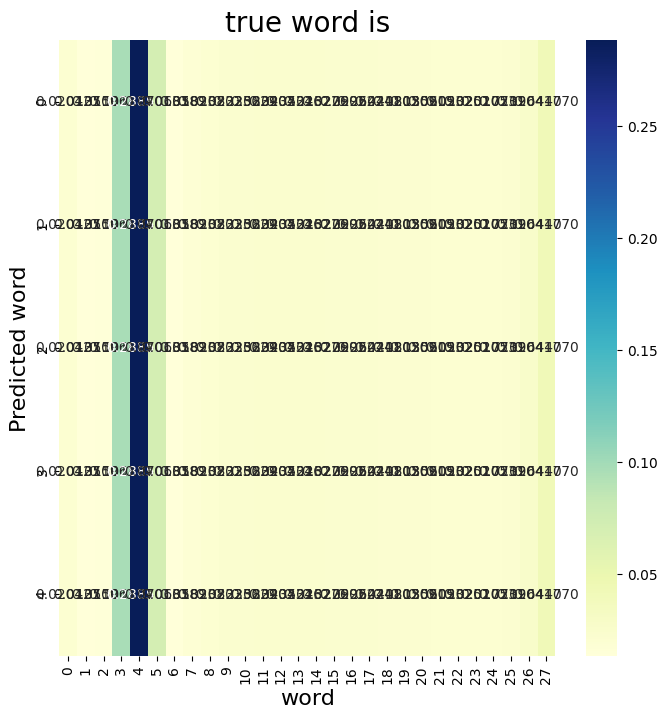

In [47]:
random_pairs = random.sample(list(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])), 10)
for i in range(10):
    
    input_data = random_pairs[i][0][:-1]
    true_value = random_pairs[i][1][1:-1]
    predicted_val, att_mat = beam_search(trained_model, input_data, preprocessed_data, params)
    
    print(input_data)
    print(true_value)
    print(predicted_val)

        
    plt.figure(figsize=(8, 8))
    axis = plt.subplot()
    mat = np.squeeze(np.array(att_mat))

    seaborn.heatmap(mat, annot=True, ax=axis, fmt='f', cmap='YlGnBu')
    
    axis.set_xlabel('word', fontsize=16)
    axis.set_ylabel('Predicted word', fontsize=16)
    plt.title('true word is', fontsize=20)
    
    label_input, label_output = [], []
    for i in range(len(input_data)):
        label_input.append(input_data[i])
    for i in range(len(predicted_val)):
        label_output.append(predicted_val[i])
    
    axis.xaxis.set_ticklabels(label_input, fontsize=10, fontweight='bold', rotation=90)
    axis.yaxis.set_ticklabels(label_output, fontsize=10, fontweight='bold', rotation=0)

    plt.tight_layout()
    plt.show()

In [ ]:
enc, dec, cor, ex = [], [], [], []
trained_model.eval()
correct_pred = 0
total_words = len(preprocessed_data['test_words'])
with tqdm(total = total_words, desc = 'Test_beam') as pbar_:
    for word, translation in zip(preprocessed_data['test_words'], preprocessed_data['test_translations']):
        ans, _ = beam_search(trained_model, word, preprocessed_data, params)
        enc.append(word[:-1])
        dec.append(ans)
        cor.append(translation[1:-1])
        if ans == translation[1:-1]:
            ex.append('Yes')
            correct_pred += 1
        else:
            ex.append('No')
        pbar_.update(1)
test_accuracy = (correct_pred / total_words) * 100
print(f'''Test Accuracy : {test_accuracy:.4f}, Correctly predicted : {correct_pred}/{total_words}''')



 

In [ ]:
def predict(model, word, preprocessed_data, params):
    data, pred = np.zeros((len(preprocessed_data['input_index']),1), dtype= int), ''
    for t, char in enumerate(word):
        data[t, 0] = preprocessed_data['input_index'][char]
    data[(t+1):,0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data,dtype = torch.int64).to(device)
    with torch.no_grad():
        if params['cell_type'] ==
        hidden, cell = model.encoder(data)
    sos_reshape = np.array(preprocessed_data['output_index'][preprocessed_data['SOS']]).reshape(1,)    
    x = torch.tensor(sos_reshape).to(device)
    for t in range(1, len(preprocessed_data['output_index'])):
        output, hidden, cell = model.decoder(x, hidden, cell)
        character = preprocessed_data['output_index_rev'][output.argmax(1).item()]
        if character != preprocessed_data['EOS']:
            pred = pred + character
        else:
            break
    return pred